# Sample

This sample shows how the lightroot project works. Note important settings are confined to a settings file so that we try
to make the slow batch jobs parameterless. The method names should be self-explantory - we sharpen images, pluck centroids and show a sample of the overlay. This process is carried out in batch to create a dataframe of blobs which is saved to txt files in the cached data folder. Having extracted centroids for all frames, the tracker builds the identities and writes the result to the cached data folder

In [1]:
%matplotlib inline
import lightroot

18/06/2018 16:32:51 INFO:loaded lightroot


# 1 Manually set file templates for processing

In [2]:
pth  ="C:/Users/mrsir/Box Sync/CYCB-GFP/uncut/Raw Data/083117/147/"
pth  ="C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)/"

lightroot.SETTINGS["stack_files"] = pth+"Run0192_tp{:0>3}.tif"
lightroot.SETTINGS["maxint_files"] = pth+"Run0192_tp{}_MIP.tif"

# 2 Loading frames

In [3]:
# sample_time_frame =15
# stack = lightroot.io.get_stack(sample_time_frame)
# lightroot.io.plotimg(stack)

# 3 Full frame detection routine

In [4]:
# id_ = 380
# stack = lightroot.io.get_stack(id_)
# out = []
# blob_centroids,stack = lightroot.blobs.detect(stack,  display_detections=False,  overlay_original_id=id_,out=out) #sharpen_iter=2, isolate_iter=2,
# lightroot.io.overlay_blobs(stack,blob_centroids,out)

# 4 Running batch process

In [5]:
#lightroot.process("C:/Users/mrsir/Box Sync/uncut/images/083117/149/", log_to_file=False)

In [6]:
# stack = lightroot.io.get_stack(98)
# lightroot.io.plotimg(stack)

# 5 Low-level steps

## isolating roots via lowband

### 2d

18/06/2018 16:32:55 INFO(117):Stack loaded from C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)/Run0192_tp117.tif
18/06/2018 16:33:00 INFO(117):estimated gaussian noise standard deviation = 0.08239829490108734
18/06/2018 16:33:01 INFO(117):using low band range for 2d data from 95,99, 50 data percentile [0.198, 0.216, 0.162]
18/06/2018 16:33:01 INFO(117):projecting 2d mask to 3d mask...
18/06/2018 16:33:16 INFO(117):did not find a clipped region adaptive threshold based on maximum label perimeters - returning image as is
18/06/2018 16:33:16 INFO(117):using low band range for 3d data from 95,99, 50 data percentile [0.227, 0.32, 0.117]
18/06/2018 16:33:16 INFO(117):using final filter from percentile low band range 0.32
18/06/2018 16:33:16 INFO(117):checking shine @ 425845.00
18/06/2018 16:33:17 INFO(117):switching adaptive threshold for final threshold as it is too small @ 0.30 < 0.32 
18/06/2018 16:33:17 INFO(117):applying adaptive cut threshold @ 0.32
18/06/2018 16:33:18 INFO

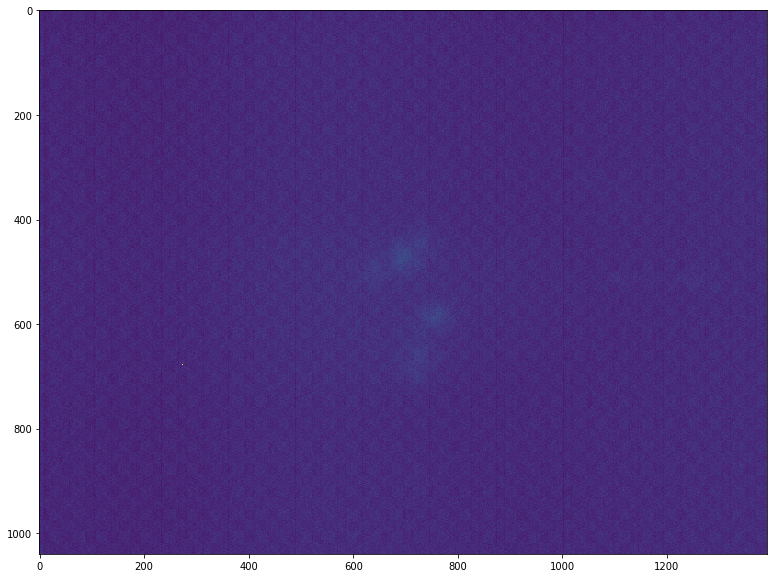

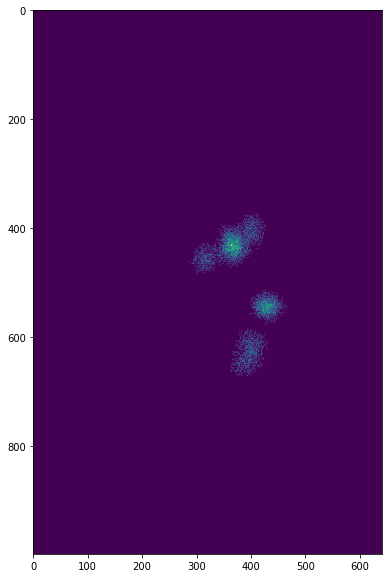

In [7]:
stack = lightroot.io.get_stack(117)
lightroot.io.plotimg(stack)
stack = lightroot.blobs.low_pass_2d_proj_root_segmentation(stack,return_early=True,denoise_img=False)
lightroot.io.plotimg(stack)

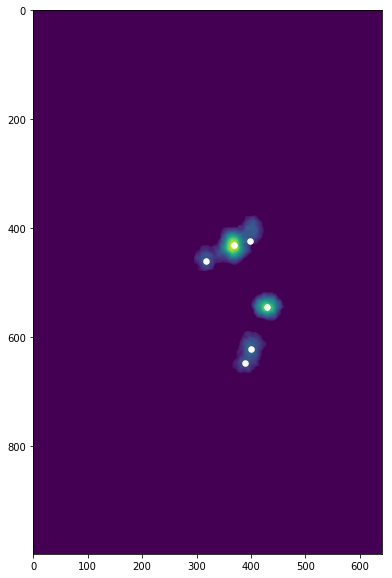

In [8]:
g2, coords = lightroot.blobs.simple_detector(stack)
lightroot.io.overlay_blobs(g2,coords)


In [ ]:
# g2 =lightroot.blobs.gaussian_filter(stack,sigma=3)
# g2 /= g2.max()
# g2[g2<0.1] = 0
# distance = lightroot.blobs.ndimage.distance_transform_edt(g2) 
# distance = lightroot.blobs.gaussian_filter(distance, sigma=1)
# distance = lightroot.blobs.maximum_filter(distance, size=15, mode='constant')
# local_maxi = lightroot.blobs.feature.peak_local_max(  distance, indices=False, min_distance=5)
# markers = lightroot.blobs.label(local_maxi)[0]
# lst = [p.coords for p in lightroot.blobs._region.collection_from_markers(markers,underlying_image=None)]
# coords = pd.DataFrame(lst,columns=["z","y", "x","r"])
# lightroot.io.plotimg(markers)
# coords

In [ ]:
#a,b =lightroot.blobs.simple_detector(g2)


In [ ]:
lightroot.io.plot_3d(a)


In [ ]:
from lightroot.blobs import _region
from scipy.ndimage import maximum_filter,gaussian_filter,label

markers = label(g2)[0]
sigma_range = [8,10]
store = None
for p in _region.collection_from_markers(markers,underlying_image=None):
    #print(p)
   
    #print(p.volume, p.brightness,p.TwoDProps.eccentricity, p.TwoDProps.area, p.TwoDProps.minor_axis_length/p.TwoDProps.major_axis_length)    
    if p.TwoDProps.eccentricity < 0.6 and p.TwoDProps.area < 2000:
        print(p.coords)
    else:
        pass
        #b,size = lightroot.blobs.filter_isolated_cells(p.image,min_size=10)
        #b = lightroot.blobs.peak_centroids(b)
        #print(b)
        #print(centroids)
    lightroot.io.plotimg(p.image) 
    store = p.image

In [ ]:
sdstore = lightroot.blobs.segment(store)
lightroot.io.plotimg(sdstore)

from skimage.measure import regionprops
for p in regionprops(sdstore):   
    lightroot.io.plotimg(p.image)


In [ ]:
#g2 = lightroot.blobs.sharpen(stack)
g2, blobs = lightroot.blobs.simple_detector(g2, min_size=10)
lightroot.io.overlay_blobs(g2,blobs)
blobs

### 3d

In [ ]:
# stack= lightroot.blobs.low_pass_root_segmentation(stack)
# lightroot.io.plotimg(stack_sample)

## sharpening root region

In [ ]:
stack = lightroot.blobs.sharpen(stack, iterations=1)
lightroot.io.plotimg(stack)

## isolating blobs in data

In [ ]:
stack = lightroot.blobs.isolate(stack)
ax = lightroot.io.plotimg(stack)

In [ ]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
# display results
import pandas as pd
im = stack.copy()


def peak_centroids(im, size=10, min_distance=10):
    image_max = ndi.maximum_filter(im, size=size, mode='constant')
    coordinates = peak_local_max(im, min_distance=min_distance)
    return pd.DataFrame(coordinates,columns=["z", "y", "x"])

blob_centroids = peak_centroids(im)
lightroot.io.overlay_blobs(stack,blobs_centroids)

## marking centroids

In [ ]:

blobs_centroids = lightroot.blobs.blob_centroids(stack, display=True, max_final_ecc=0.95,min_final_volume=1000, underlying_image=stack)
lightroot.io.overlay_blobs(stack,blobs_centroids)

In [ ]:
#https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm